In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astroquery.simbad import Simbad

In [95]:
def get_HIPname(name): # CHANGE THIS: INSTEAD OF SEARCHING IN SIMBAD USE APF_NAME_CONVERSION (at least for apf)
    if name.startswith('HIP'):
            HIP_name = name
    else:      
        try:
            result_table = Simbad.query_objectids(name)
            alt_names = result_table.to_pandas()
            alt_names = alt_names.iloc[:,0].str.decode('utf-8') #gets rid of weird formatting
            HIP_name = alt_names[alt_names.str.contains("HIP")]
            if len(HIP_name) == 0:
                HIP_name = 'None'
                print(name + ' has no HIP name in SIMBAD') #this should never occur since only using stars with HIP names for finding overlap between apf and Yee
            elif len(HIP_name) == 1:
                HIP_name = str(HIP_name.iloc[0]) # makes it a string instead of dataframe with one cell  
            else:
                print('more than one HIP name found for ' + name)
        except AttributeError:
            HIP_name = 'None'
            print(name + ': SIMBAD search error (likely \'No known catalog could be found\' or \'this identifier has an incorrect format for catalog\'') # should not happen
    return HIP_name


In [176]:
# read in files
apf_data = pd.read_csv('specmatch_results.csv')
yee_data = pd.read_csv('yee_library_full.csv')


# process names in file so be serachable by Simbad (move this logic to inside get_HIPname loop to speed up!)
for row in range(len(apf_data)):
    name = apf_data.iloc[row,0]
    if name[0].isdigit():
        apf_data.iloc[row,0] = 'HD' + name
    elif name.startswith('K0'):
        apf_data.iloc[row,0] = 'KOI-' + name[1:]
    elif name.startswith('EPIC-'):
        apf_data.iloc[row,0] = 'EPIC' + name[5:]


# sort by HIP name of stars for easy comparison
apf_HIP = apf_data
for row in range(len(apf_data)):
    apf_HIP.iloc[row,0] = get_HIPname(apf_data.iloc[row,0]).replace(' ','')
apf_HIP.rename(columns = {'apf_name':'HIP_name'}, inplace = True)
apf_sorted = apf_HIP.sort_values(by=['HIP_name'])

yee_HIP = yee_data
drop_rows = []
for row in range(len(yee_data)):
    yee_HIP.iloc[row,0] = get_HIPname(yee_data.iloc[row,0]).replace(' ','')  
    if not(apf_sorted["HIP_name"].str.contains(yee_HIP.iloc[row,0]).any()):
        drop_rows = drop_rows + [row]
yee_HIP = yee_HIP.drop(drop_rows)
yee_HIP.rename(columns = {'Name':'HIP_name'}, inplace = True)
yee_sorted = yee_HIP.sort_values(by=['HIP_name'])

# THIS IS NOT A LONG-TERM SOLUTION! SEE NOTES from 7/5 FOR WHY.
#apf_sorted_unique = list(dict.fromkeys(apf_sorted['HIP_name']))
apf_sorted_unique = apf_sorted.drop_duplicates(subset = 'HIP_name')

/opt/conda/lib/python3.7/site-packages/astroquery-0.4.1.dev0-py3.7.egg/astroquery/simbad/core.py:138: UserWarning: Warning: The script line number 2 raised an error (recorded in the `errors` attribute of the result table): Identifier not found in the database : HD 124257A
  (error.line, error.msg))


HD 124257A  : SIMBAD search error (likely 'No known catalog could be found' or 'this identifier has an incorrect format for catalog'
HD 3684      has no HIP name in SIMBAD
KOI-1925     has no HIP name in SIMBAD
KOI-1612     has no HIP name in SIMBAD
KIC 10018963 has no HIP name in SIMBAD
KIC 10355856 has no HIP name in SIMBAD
KIC 10516096 has no HIP name in SIMBAD
KIC 10644253 has no HIP name in SIMBAD
KIC 10709834 has no HIP name in SIMBAD
KIC 11026764 has no HIP name in SIMBAD
KIC 11137075 has no HIP name in SIMBAD
KIC 11244118 has no HIP name in SIMBAD
KIC 11414712 has no HIP name in SIMBAD
KIC 11717120 has no HIP name in SIMBAD
KIC 12009504 has no HIP name in SIMBAD
KIC 1435467  has no HIP name in SIMBAD
KIC 3427720  has no HIP name in SIMBAD
KIC 3656476  has no HIP name in SIMBAD
KIC 5021689  has no HIP name in SIMBAD
KIC 5184732  has no HIP name in SIMBAD
KIC 5596656  has no HIP name in SIMBAD
KIC 5773345  has no HIP name in SIMBAD
KIC 5955122  has no HIP name in SIMBAD
KIC 61160

 MAKE SURE THEY ARE SORTED BY NAME CORRECTLY SO NAMES MATCH UP! 


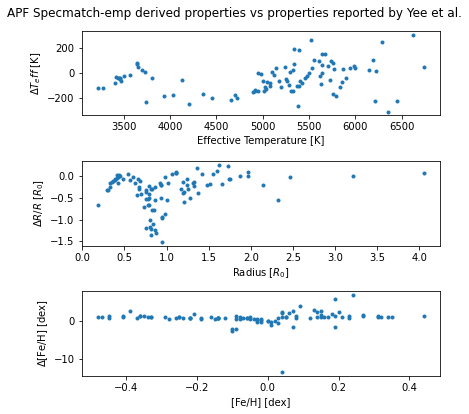

In [179]:
# plot certain properties to compare
print(' MAKE SURE THEY ARE SORTED BY NAME CORRECTLY SO NAMES MATCH UP! ')

apf_Teff = apf_sorted_unique.iloc[:,1].to_numpy()
yee_Teff = yee_sorted.iloc[:,1].to_numpy()
apf_R = apf_sorted_unique.iloc[:,3].to_numpy()
yee_R = yee_sorted.iloc[:,3].to_numpy()
apf_feh = apf_sorted_unique.iloc[:,7].to_numpy()
yee_feh = yee_sorted.iloc[:,7].to_numpy()
fig, axs = plt.subplots(3, 1, figsize = (6,6)) 
axs[0].plot(yee_Teff,yee_Teff-apf_Teff,'.') #Is this right to use Yee as the x-axis, 'correct' T value?
axs[0].set_xlabel('Effective Temperature [K]')
axs[0].set_ylabel('$\Delta T_eff$ [K]')
axs[1].plot(yee_R, (yee_R-apf_R)/yee_R,'.') # why normalize to R?
axs[1].set_xlabel('Radius [$R_0$]')
axs[1].set_ylabel('$\Delta R/ R$ [$R_0$]')
axs[2].plot(yee_feh, yee_feh/apf_feh,'.')
axs[2].set_xlabel('[Fe/H] [dex]')
axs[2].set_ylabel('$\Delta$[Fe/H] [dex]')
fig.suptitle('APF Specmatch-emp derived properties vs properties reported by Yee et al.')
#fig.tight_layout(pad=1.0)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('APF_Yee_comparison.png')

In [178]:
plt.savefig('APF_Yee_comparison.png')


<Figure size 432x288 with 0 Axes>